In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import math

In [4]:
# ----------------------------
# Fourier Neural Operator Layer
# ----------------------------
class FourierLayer(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(FourierLayer, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1
        self.modes2 = modes2
        self.scale = 1 / (in_channels * out_channels)
        self.weights = nn.Parameter(
            self.scale * torch.rand(in_channels, out_channels, modes1, modes2, dtype=torch.cfloat)
        )

    def compl_mul2d(self, input, weights):
        return torch.einsum("bixy, ioxy -> boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        x_ft = torch.fft.rfft2(x)
        avail_modes1 = min(self.modes1, x.size(-2))
        avail_modes2 = min(self.modes2, x.size(-1) // 2 + 1)
        out_ft = torch.zeros(
            batchsize, self.out_channels, x.size(-2), x.size(-1) // 2 + 1,
            device=x.device, dtype=torch.cfloat
        )
        out_ft[:, :, :avail_modes1, :avail_modes2] = self.compl_mul2d(
            x_ft[:, :, :avail_modes1, :avail_modes2],
            self.weights[:, :, :avail_modes1, :avail_modes2]
        )
        x = torch.fft.irfft2(out_ft, s=x.shape[-2:])
        return x

# ----------------------------
# Fourier Feature Mapping (for coordinate lifting)
# ----------------------------
class FourierFeatureMapping(nn.Module):
    def __init__(self, input_dim=2, mapping_size=64, scale=10.0):
        """
        Maps 2D coordinates to a (2*mapping_size)-dimensional feature.
        """
        super(FourierFeatureMapping, self).__init__()
        self.mapping_size = mapping_size
        self.register_buffer("B", torch.randn(input_dim, mapping_size) * scale)
    
    def forward(self, coords):
        projection = 2 * math.pi * torch.matmul(coords, self.B)
        fourier_features = torch.cat([torch.cos(projection), torch.sin(projection)], dim=-1)
        return fourier_features.permute(0, 3, 1, 2)

def get_coord_grid(batch_size, height, width, device):
    xs = torch.linspace(0, 1, width, device=device)
    ys = torch.linspace(0, 1, height, device=device)
    grid_y, grid_x = torch.meshgrid(ys, xs, indexing='ij')
    grid = torch.stack((grid_x, grid_y), dim=-1)
    grid = grid.unsqueeze(0).repeat(batch_size, 1, 1, 1)
    return grid

# ----------------------------
# Modified SuperResUNet for 10-to-10 mapping (NS version)
# ----------------------------
class SuperResUNet(nn.Module):
    def __init__(self, in_channels=10, lift_dim=128, mapping_size=64, mapping_scale=5.0):
        super(SuperResUNet, self).__init__()
        # Fourier feature mapping: maps coordinates to features.
        self.fourier_mapping = FourierFeatureMapping(input_dim=2, mapping_size=mapping_size, scale=mapping_scale)
        # Lifting: concatenate the input with the Fourier features.
        # New channel dimension = in_channels + 2*mapping_size.
        self.lift = nn.Conv2d(in_channels + 2 * mapping_size, lift_dim, kernel_size=1)
        # Encoder: expand channel dimensions.
        self.encoder = nn.Sequential(
            nn.Conv2d(lift_dim, lift_dim * 2, 3, padding=1),
            nn.GELU(),
            nn.Conv2d(lift_dim * 2, lift_dim * 2, 3, padding=1),
            nn.GELU(),
            nn.MaxPool2d(2)
        )
        # Bottleneck with Fourier layer.
        self.bottleneck = nn.Sequential(
            nn.Conv2d(lift_dim * 2, lift_dim * 2, 3, padding=1),
            nn.GELU(),
            FourierLayer(lift_dim * 2, lift_dim * 2, modes1=32, modes2=24),
            nn.BatchNorm2d(lift_dim * 2),
            nn.GELU(),
            nn.Conv2d(lift_dim * 2, lift_dim * 2, 3, padding=1),
            nn.GELU()
        )
        # Decoder: progressively reduce channels back to the target 10 channels.
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Conv2d(lift_dim * 2, lift_dim, 3, padding=1),
            nn.GELU(),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Conv2d(lift_dim, lift_dim // 2, 3, padding=1),
            nn.GELU(),
            nn.Upsample(size=128, mode='bilinear'),
            nn.Conv2d(lift_dim // 2, 32, 3, padding=1),
            nn.GELU(),
            nn.Conv2d(32, in_channels, 3, padding=1)
        )
    
    def forward(self, x):
        B, C, H, W = x.shape
        device = x.device
        coords = get_coord_grid(B, H, W, device)
        fourier_feats = self.fourier_mapping(coords)
        x_cat = torch.cat([x, fourier_feats], dim=1)
        x_lift = self.lift(x_cat)
        x_enc = self.encoder(x_lift)
        x_bottleneck = self.bottleneck(x_enc)
        x_dec = self.decoder(x_bottleneck)
        return x_dec

In [ ]:
# ----------------------------
# Evaluation: Iterative Future Extrapolation with AB3 on the Coarse Grid
# ----------------------------

device = 'cpu'#torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Initialize models and load saved weights
model_u = SuperResUNet(in_channels=100).to(device)
#model_u.load_state_dict(torch.load("/pscratch/sd/h/hbassi/models/fine_tuning_Ntime_NS_64to128_nu=1e-3_mode=10_best_model_new.pth"))
#model_u.load_state_dict(torch.load('/pscratch/sd/h/hbassi/models/fine_tuning_NS_64to128_nu=1e-3_mode=10_complex_best_model.pth'))
model_u.load_state_dict(torch.load(f'/pscratch/sd/h/hbassi/models/fine_tuning_NS_64to128_nu=1e-3_mode=7-42_complex_best_model.pth'))
model_u.eval()

In [14]:
import numpy as np
import torch
import math
from tqdm import trange

#########################################
# NEW NS SOLVER FUNCTIONS (Explicit Euler)
#########################################
def de_alias(f_hat, N):
    """
    Applies 2/3-rule de-aliasing on the Fourier coefficients.
    """
    k = np.fft.fftfreq(N) * N
    KX, KY = np.meshgrid(k, k)
    cutoff = N // 3
    mask = (np.abs(KX) < cutoff) & (np.abs(KY) < cutoff)
    return f_hat * mask

def spectral_filter(f_hat, k_cutoff):
    """
    Filters the Fourier coefficients to only include modes with |kx|, |ky| <= k_cutoff.
    """
    N = f_hat.shape[0]
    k = np.fft.fftfreq(N) * N
    KX, KY = np.meshgrid(k, k)
    mask = (np.abs(KX) <= k_cutoff) & (np.abs(KY) <= k_cutoff)
    return f_hat * mask

def compute_streamfunction(omega_hat, ksq, eps=1e-10):
    """
    Computes streamfunction in Fourier space:
       psi_hat = -omega_hat / ksq (with zero-frequency handled)
    """
    psi_hat = np.zeros_like(omega_hat, dtype=complex)
    psi_hat[ksq > eps] = -omega_hat[ksq > eps] / ksq[ksq > eps]
    return psi_hat

def navier_stokes_solver(omega0, nu, dt, nsteps, N, k_cutoff=None):
    """
    Solves the 2D Navier–Stokes equations (vorticity formulation) using a pseudo-spectral method.
    
    Inputs:
      omega0: initial vorticity field (N x N numpy array)
      nu: viscosity (scalar)
      dt: time step size
      nsteps: number of time steps to simulate (use 1 for a single forward step)
      N: spatial resolution (assumed square grid)
      k_cutoff: (optional) if provided, filters Fourier modes to |kx|,|ky| <= k_cutoff
      
    Returns:
      series: time series of vorticity fields (shape: [nsteps+1, N, N])
    """
    L = 1.0
    dx = L / N

    # Create wave number grid (with 2*pi scaling for derivatives)
    k = np.fft.fftfreq(N, d=dx) * 2 * np.pi
    KX, KY = np.meshgrid(k, k)
    ksq = KX**2 + KY**2
    ksq[0, 0] = 1e-10  # avoid division by zero

    # Initialize vorticity
    omega = omega0.copy()
    series = [omega.copy()]

    for step in range(nsteps):
        # Fourier transform of current vorticity
        omega_hat = np.fft.fft2(omega)
        
        # Compute streamfunction in Fourier space
        psi_hat = compute_streamfunction(omega_hat, ksq)
        
        # Compute velocity components via spectral differentiation:
        u = np.real(np.fft.ifft2(1j * KY * psi_hat))
        v = -np.real(np.fft.ifft2(1j * KX * psi_hat))
        
        # Compute spatial derivatives of omega for the nonlinear term
        domega_dx = np.real(np.fft.ifft2(1j * KX * omega_hat))
        domega_dy = np.real(np.fft.ifft2(1j * KY * omega_hat))
        
        # Nonlinear (advection) term
        nonlinear = u * domega_dx + v * domega_dy
        
        # Compute Laplacian in Fourier space then invert FFT
        lap_omega = np.real(np.fft.ifft2(-ksq * omega_hat))
        
        # Explicit Euler update
        omega_new = omega + dt * (-nonlinear + nu * lap_omega)
        
        # Apply Fourier filtering: if k_cutoff is provided, use it; otherwise, de-alias.
        omega_new_hat = np.fft.fft2(omega_new)
        if k_cutoff is not None:
            omega_new_hat = spectral_filter(omega_new_hat, k_cutoff)
        else:
            omega_new_hat = de_alias(omega_new_hat, N)
        omega = np.real(np.fft.ifft2(omega_new_hat))
        
        series.append(omega.copy())
    
    return np.array(series)

def project_to_coarse(omega_fine, N_coarse):
    """
    Projects a field from a fine grid to a coarse grid via Fourier truncation.
    
    Inputs:
      omega_fine: fine grid field (N_fine x N_fine numpy array)
      N_coarse: desired coarse grid resolution (must be smaller than N_fine)
      
    Returns:
      omega_coarse: projected field on the coarse grid (N_coarse x N_coarse numpy array)
    """
    N_fine = omega_fine.shape[0]
    omega_hat_fine = np.fft.fft2(omega_fine)
    omega_hat_fine_shifted = np.fft.fftshift(omega_hat_fine)
    start = (N_fine - N_coarse) // 2
    end = start + N_coarse
    omega_hat_coarse_shifted = omega_hat_fine_shifted[start:end, start:end]
    omega_hat_coarse = np.fft.ifftshift(omega_hat_coarse_shifted)
    omega_coarse = np.real(np.fft.ifft2(omega_hat_coarse, s=(N_coarse, N_coarse)))
    return omega_coarse

#########################################
# NS Update on the Coarse Sliding Window
#########################################
def coarse_time_step_NS_new(coarse_field, dt, nu, N):
    """
    Advances the coarse sliding window (of 10 snapshots) one time step using the new NS solver.
    The solver is applied independently on each channel.
    
    Inputs:
      coarse_field: Tensor of shape [B, 10, H, W] (with B typically 1)
      dt         : time step size
      nu         : viscosity
      N          : coarse grid resolution (H = W = N)
      
    Returns:
      Updated coarse field: Tensor of shape [B, 10, H, W]
    """
    B, num_snap, H, W = coarse_field.shape
    updated_channels = []
    for i in range(num_snap):
        # Convert the i-th snapshot from tensor to NumPy
        field_np = coarse_field[0, i, :, :].cpu().numpy()
        # Advance one time step using the new NS solver (nsteps=1)
        series = navier_stokes_solver(field_np, nu, dt, nsteps=1, N=N, k_cutoff=None)
        updated = series[-1]  # New state for this channel
        updated_channels.append(torch.tensor(updated, dtype=torch.float32, device=coarse_field.device))
    updated_field = torch.stack(updated_channels, dim=0)
    return updated_field.unsqueeze(0)

#########################################
# DATA LOADER
#########################################
def load_single_sample_full(idx=0):
    """
    Loads a full trajectory from file.
    Assumes the file contains an array of shape [T, H, W].
    """
    fine_u = np.load(f'/pscratch/sd/h/hbassi/NavierStokes_test_traj_coarse_nu={1e-3}_mode=7-42_no_dealias.npy')
    sample_u = fine_u
    sample_u = torch.tensor(sample_u, dtype=torch.float32)
    return sample_u

#########################################
# NOTEBOOK INTEGRATION & ITERATIVE EXTRAPOLATION
#########################################
device = 'cpu'  # or torch.device('cuda:0') if available

# Initialize your super-resolution model.
# (Ensure that SuperResUNet is defined or imported before running.)
model_u = SuperResUNet(in_channels=100).to(device)
model_u.load_state_dict(torch.load('/pscratch/sd/h/hbassi/models/fine_tuning_NS_64to128_nu=1e-3_mode=7-42_complex_best_model.pth'))
model_u.eval()

# Coarse grid parameters (assume domain [0,1]x[0,1])
downsample_factor = 2
Lx = 1.0
Nx_fine = 128           # Fine grid resolution (assumed square)
Nx_coarse = Nx_fine // downsample_factor
dt = 0.01               # Time step for coarse evolution
nu = 1e-3               # Viscosity
num_extrap_steps = 900  # Number of extrapolation steps

# Load the full fine trajectory (assumed shape [T, H, W])
sample_u = load_single_sample_full(idx=2)
print("Fine field shape:", sample_u.shape)

# Fine sliding window: the first 100 time steps
fine_window_u = sample_u[:100].clone()  # shape: [100, H, W]

# Initialize the coarse sliding window by projecting the first 10 fine snapshots.
coarse_window_list = []
for i in range(100):
    # Use the new projection (Fourier truncation)
    coarse_snapshot_np = project_to_coarse(fine_window_u[i].cpu().numpy(), Nx_coarse)
    coarse_snapshot = torch.tensor(coarse_snapshot_np, dtype=torch.float32, device=device)
    coarse_window_list.append(coarse_snapshot)
coarse_window = torch.stack(coarse_window_list, dim=0)  # shape: [10, H_coarse, W_coarse]

# Main iterative extrapolation loop:
pred_sequence_u = []
for step in trange(num_extrap_steps):
    # --- Forward Step: Update the Coarse Sliding Window ---
    updated_coarse = coarse_time_step_NS_new(coarse_window.unsqueeze(0), dt, nu, Nx_coarse).squeeze(0)  # shape: [10, H_coarse, W_coarse]
    
    # Extract the new coarse state from the last snapshot in the window.
    new_coarse_state = updated_coarse[-1]  # shape: [H_coarse, W_coarse]
    
    # Update the sliding window: drop the oldest snapshot and append the new state.
    coarse_window = torch.cat([coarse_window[1:], new_coarse_state.unsqueeze(0)], dim=0)
    
    # --- Superresolution Prediction ---
    # Prepare the coarse input for the model: expected shape [B, 10, H_coarse, W_coarse]
    coarse_input = coarse_window.unsqueeze(0)
    
    # Use the super-resolution model to predict the next fine state.
    pred_fine = model_u(coarse_input)  # Expected output: [1, 10, H_fine, W_fine]
    next_fine = pred_fine[:, -1, :, :]   # Extract the immediate next fine state.
    
    # Save the predicted fine state.
    pred_sequence_u.append(next_fine.squeeze(0))
    
    # Update the fine sliding window: drop the oldest fine state and append the new prediction.
    fine_window_u = torch.cat([fine_window_u[1:], next_fine], dim=0)

# Stack predictions: [num_extrap_steps, H_fine, W_fine]
pred_sequence_u = torch.stack(pred_sequence_u, dim=0)
gt_u = sample_u[100:]  # Ground truth for evaluation

print("Predicted sequence shape:", pred_sequence_u.shape)
print("Ground truth shape:", gt_u.shape)


Fine field shape: torch.Size([1001, 128, 128])


100%|██████████| 900/900 [03:21<00:00,  4.46it/s]


Predicted sequence shape: torch.Size([900, 128, 128])
Ground truth shape: torch.Size([901, 128, 128])


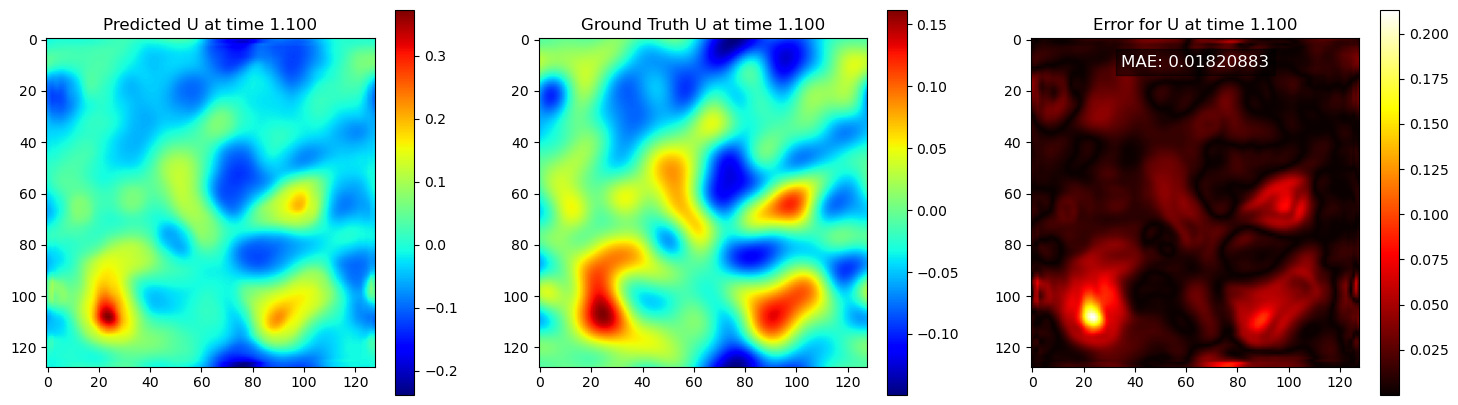

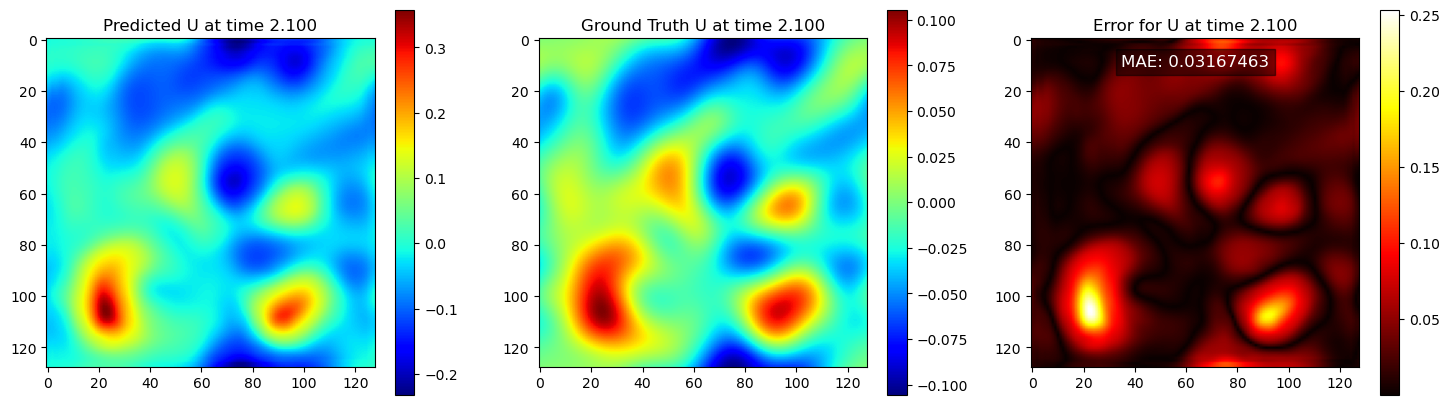

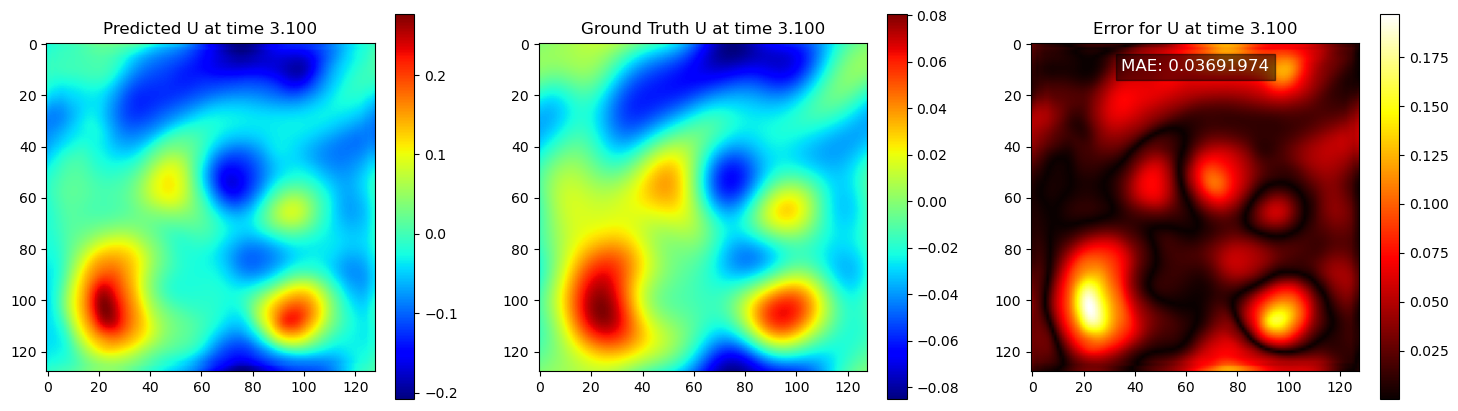

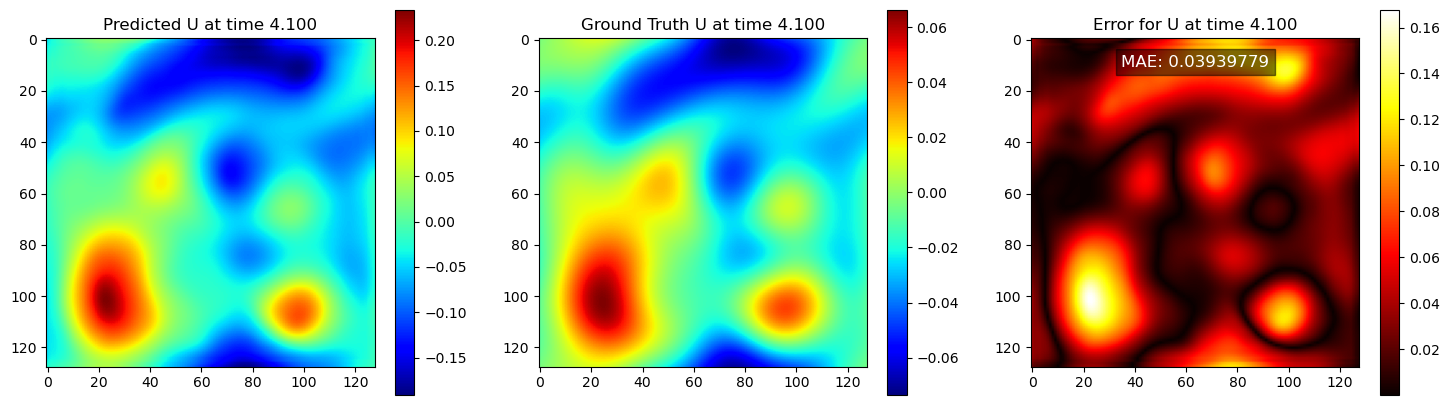

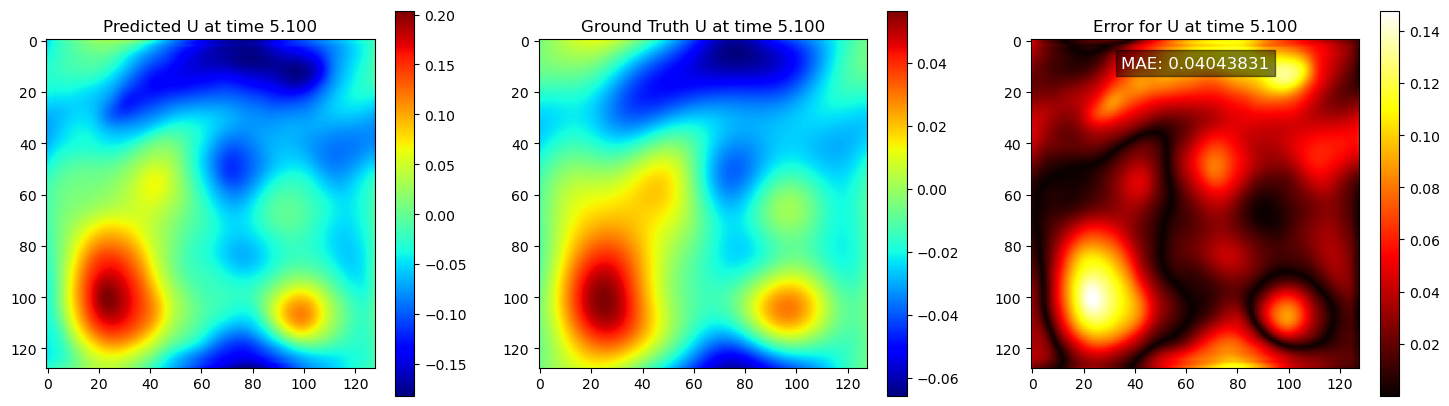

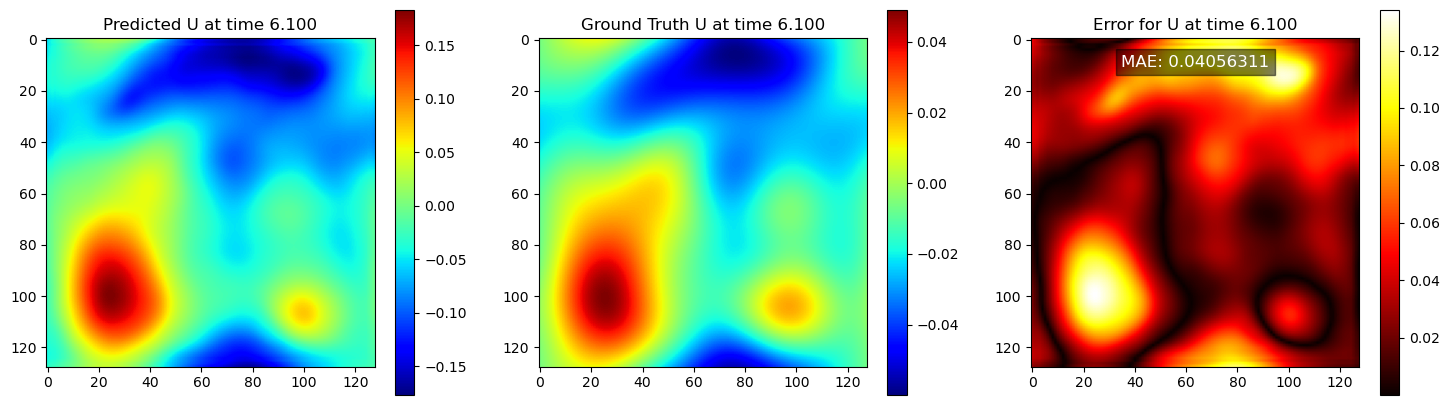

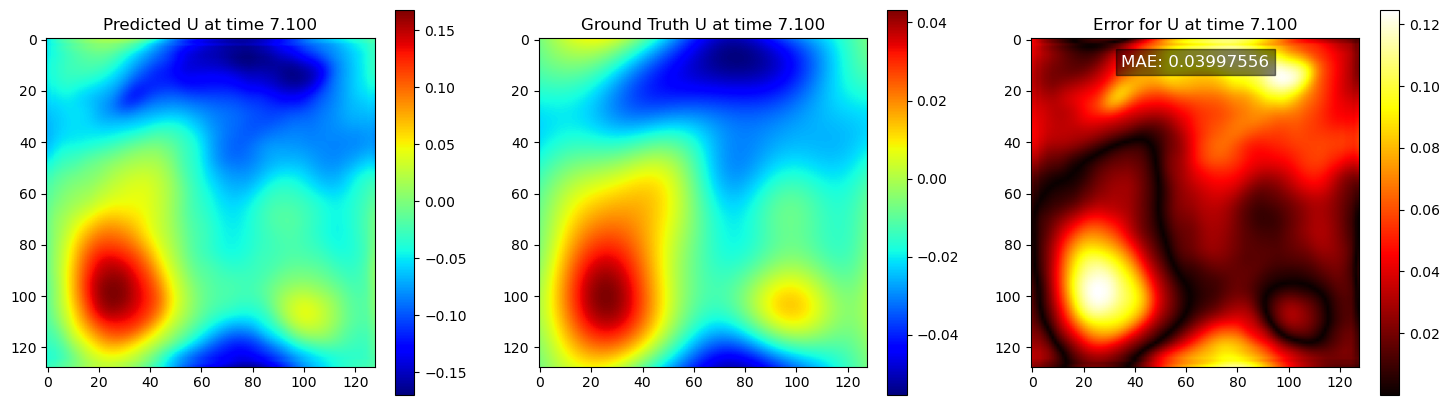

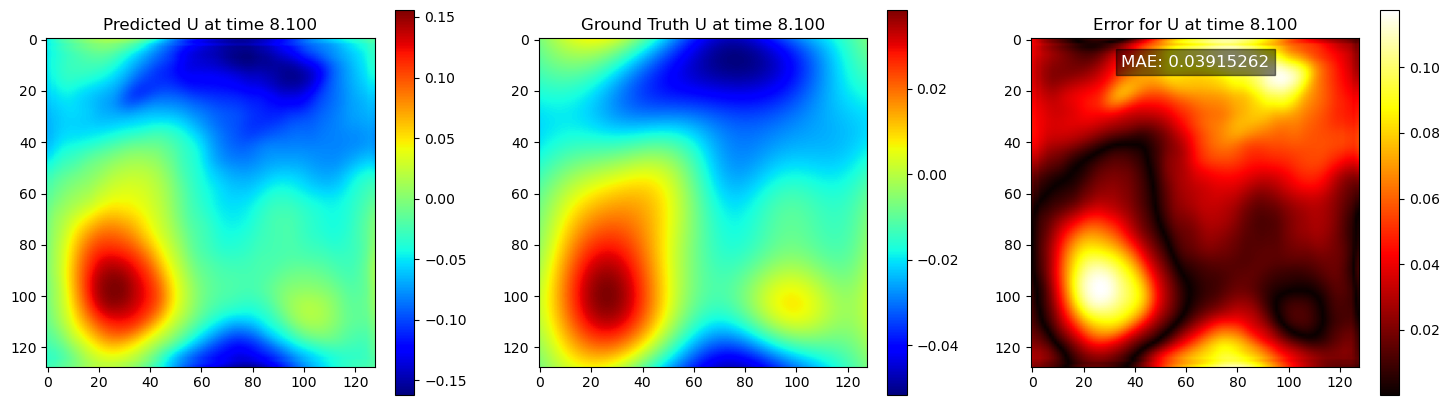

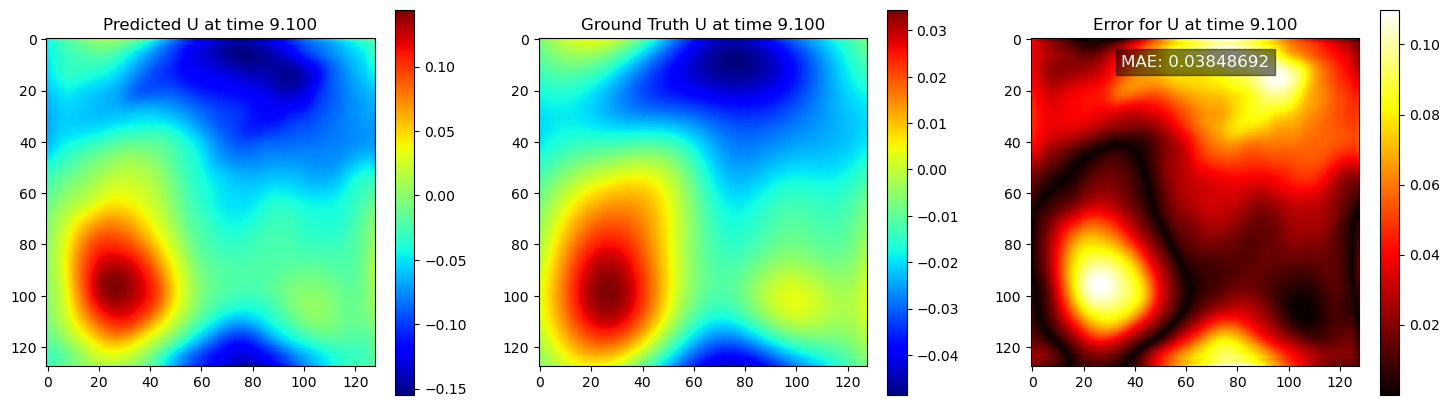

In [15]:
maes = []
for i in range(0, num_extrap_steps, 100):
    plt.figure(figsize=(18, 5))
    time_value = 1 + 0.01 * (10 + i)
    time_str = f"{time_value:.3f}" 

        # Left plot: Predicted U
    plt.subplot(1, 3, 1)
    plt.imshow(pred_sequence_u[i].detach().cpu().numpy(), cmap='jet')
    plt.title(f"Predicted U at time {time_str}")
    plt.colorbar()
    
    # Middle plot: Ground Truth U
    plt.subplot(1, 3, 2)
    plt.imshow(gt_u[i].detach().cpu().numpy(), cmap='jet')
    plt.title(f"Ground Truth U at time {time_str}")
    plt.colorbar()
    
    # Right plot: Absolute Error (AE)
    plt.subplot(1, 3, 3)
    mae = abs(pred_sequence_u[i] - gt_u[i]).detach().cpu().numpy()
    plt.imshow(mae, cmap='hot')
    plt.title(f"Error for U at time {time_str}")
    plt.colorbar()
    overall_mae = np.mean(mae)  
    maes.append(overall_mae)
    plt.text(0.5, 0.95, f'MAE: {overall_mae:.8f}',
             transform=plt.gca().transAxes,
             fontsize=12, color='white', ha='center', va='top',
             bbox=dict(facecolor='black', alpha=0.5))
    plt.show()

In [20]:
cg_dyns = np.load( f'/pscratch/sd/h/hbassi/NavierStokes_test_traj_coarse_nu={1e-3}_mode=7-42_no_dealias_true.npy')[100:]

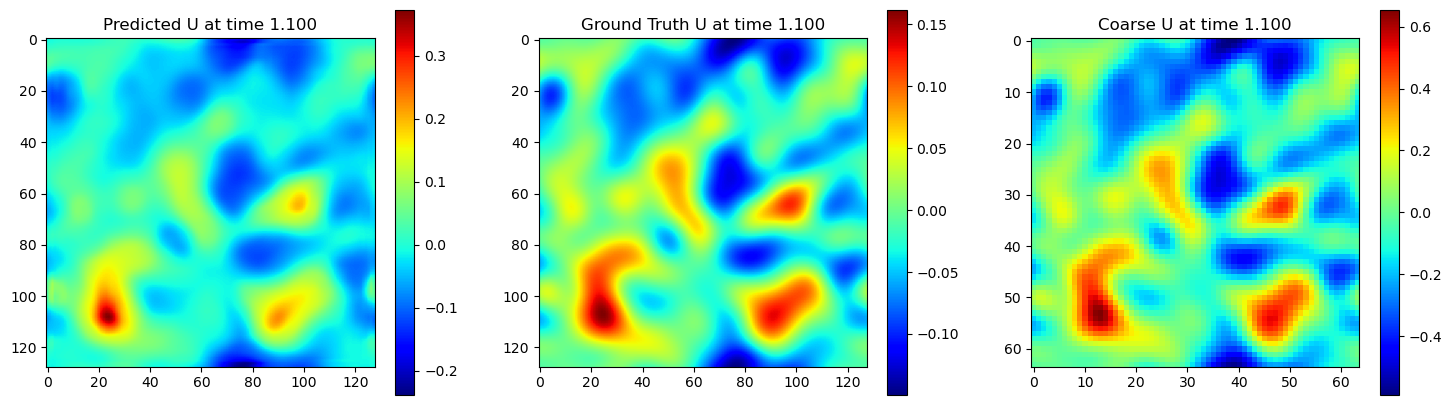

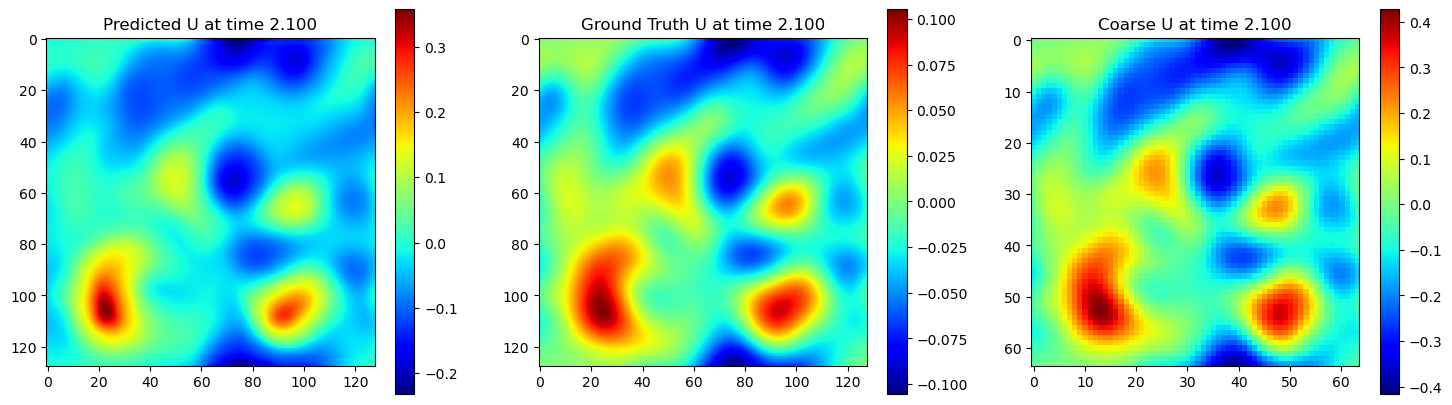

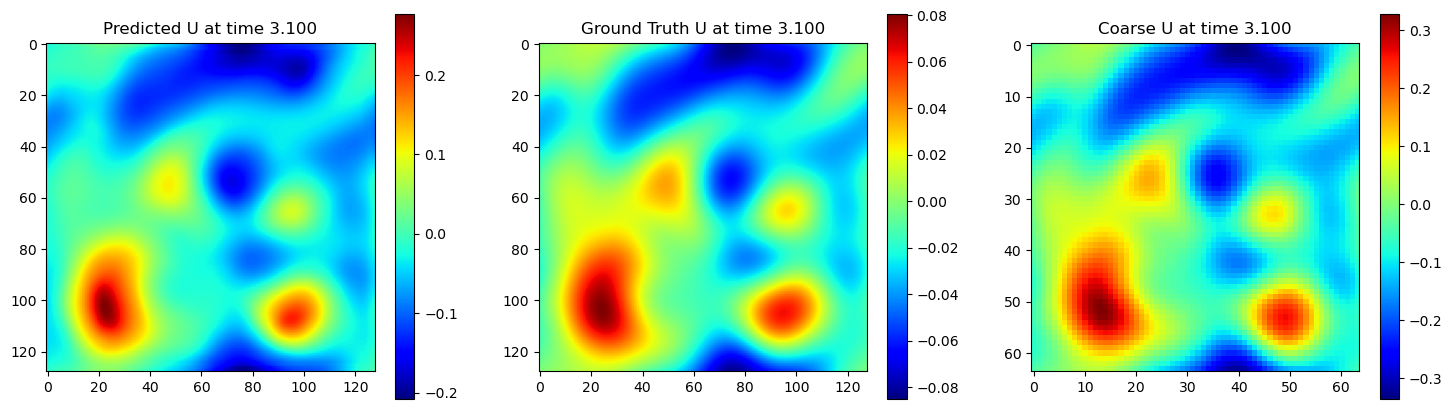

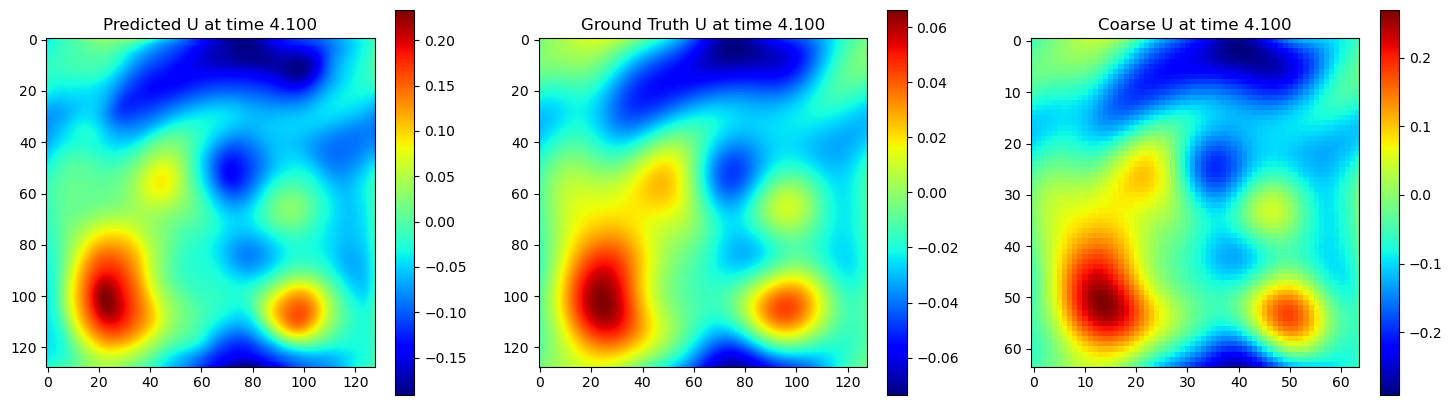

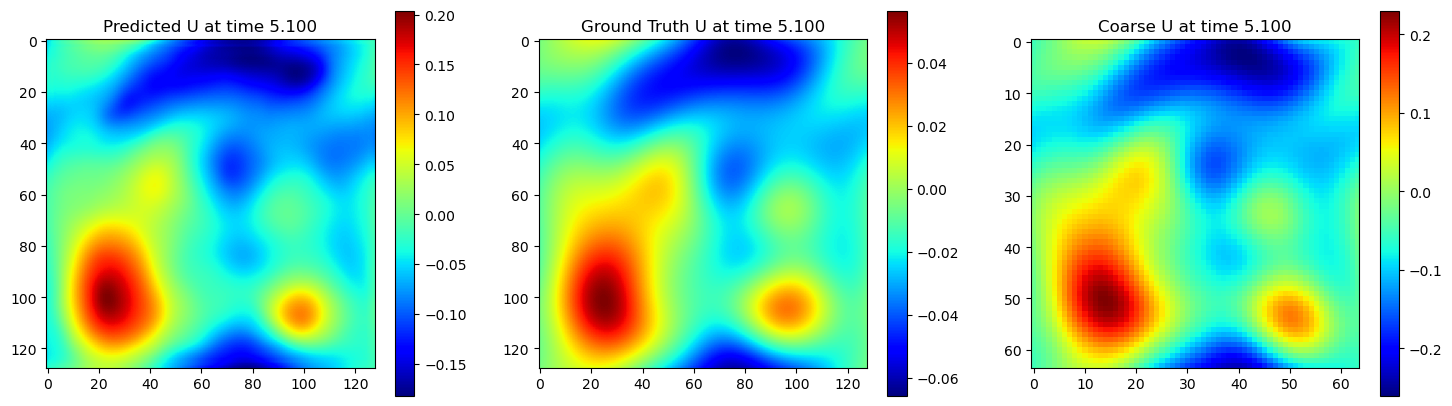

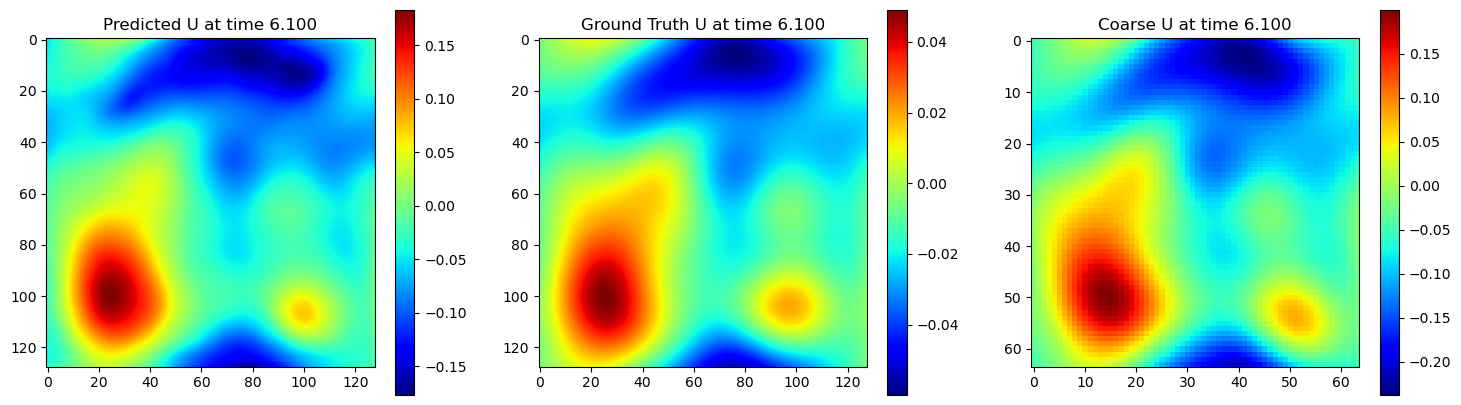

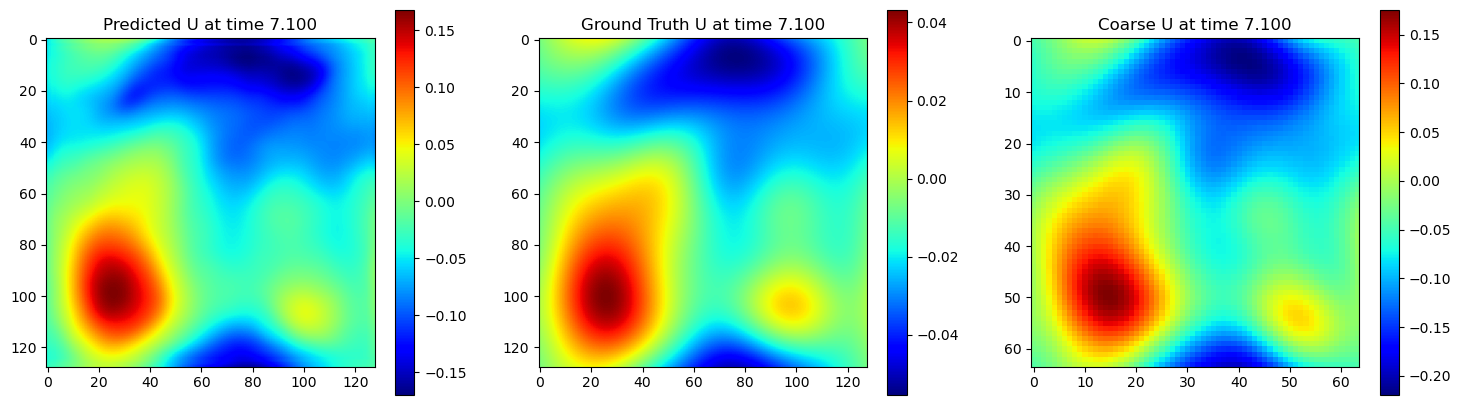

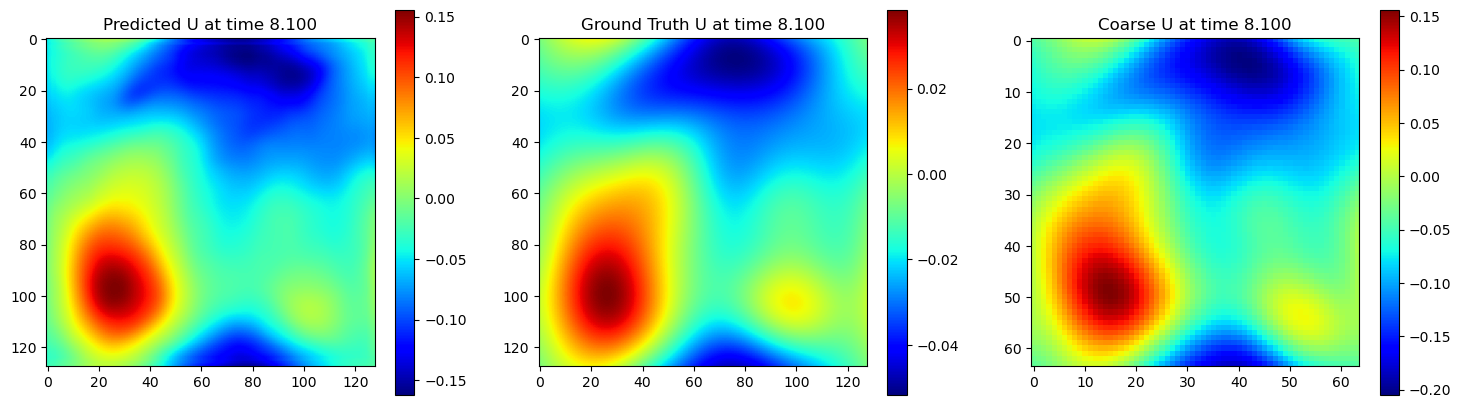

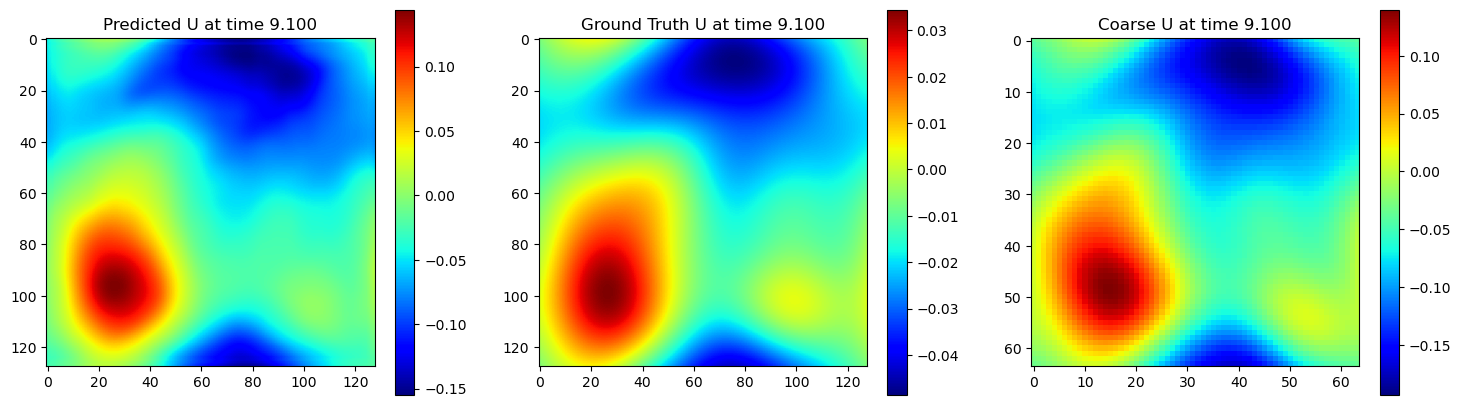

In [22]:
maes = []
for i in range(0, num_extrap_steps, 100):
    plt.figure(figsize=(18, 5))
    time_value = 1 + 0.01 * (10 + i)
    time_str = f"{time_value:.3f}" 

        # Left plot: Predicted U
    plt.subplot(1, 3, 1)
    plt.imshow(pred_sequence_u[i].detach().cpu().numpy(), cmap='jet')
    plt.title(f"Predicted U at time {time_str}")
    plt.colorbar()
    
    # Middle plot: Ground Truth U
    plt.subplot(1, 3, 2)
    plt.imshow(gt_u[i].detach().cpu().numpy(), cmap='jet')
    plt.title(f"Ground Truth U at time {time_str}")
    plt.colorbar()
    
    # Right plot: Absolute Error (AE)
    plt.subplot(1, 3, 3)
    plt.imshow(cg_dyns[i], cmap='jet')
    plt.title(f"Coarse U at time {time_str}")
    plt.colorbar()
    plt.show()

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
import imageio
import torch  # assuming torch is already imported and used in your code

# Create a folder to store the frames
os.makedirs('frames', exist_ok=True)

maes = []
filenames = []

for i in trange(0, 900):
    plt.figure(figsize=(18, 5))
    time_value = 1 + 0.01 * (10 + i)
    time_str = f"{time_value:.3f}" 

    # Left plot: Predicted U
    plt.subplot(1, 3, 1)
    plt.imshow(pred_sequence_u[i].detach().cpu().numpy(), cmap='jet')
    plt.title(f"Predicted U at time {time_str}")
    plt.colorbar()
    
    # Middle plot: Ground Truth U
    plt.subplot(1, 3, 2)
    plt.imshow(gt_u[i].detach().cpu().numpy(), cmap='jet')
    plt.title(f"Ground Truth U at time {time_str}")
    plt.colorbar()
    
    # Right plot: Absolute Error (AE)
    plt.subplot(1, 3, 3)
    mae = abs(pred_sequence_u[i] - gt_u[i]).detach().cpu().numpy()
    plt.imshow(mae, cmap='hot')
    plt.title(f"Error for U at time {time_str}")
    plt.colorbar()
    
    overall_mae = np.mean(mae)
    maes.append(overall_mae)
    # plt.text(0.5, 0.95, f'MAE: {overall_mae:.8f}',
    #          transform=plt.gca().transAxes,
    #          fontsize=12, color='white', ha='center', va='top',
    #          bbox=dict(facecolor='black', alpha=0.5))
    
    # Save the figure as a PNG file
    filename = f"frames/frame_{i:03d}.png"
    plt.savefig(filename)
    filenames.append(filename)
    plt.close()
    

# Create a GIF from the saved images
gif_filename = 'animation.gif'
with imageio.get_writer(gif_filename, mode='I', duration=0.5) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

print(f"GIF saved as {gif_filename}")

# Optionally, remove the temporary frame files if they're no longer needed
for filename in filenames:
    os.remove(filename)


100%|██████████| 900/900 [06:49<00:00,  2.20it/s]
/tmp/ipykernel_2269745/2184527397.py:55: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


GIF saved as animation.gif


In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
import imageio
import torch  # assuming torch is already imported and used in your code

# Create a folder to store the frames
os.makedirs('frames', exist_ok=True)

maes = []
filenames = []

for i in trange(0, 900):
    plt.figure(figsize=(18, 5))
    time_value = 1 + 0.01 * (10 + i)
    time_str = f"{time_value:.3f}" 

    # Left plot: Predicted U
    plt.subplot(1, 3, 1)
    plt.imshow(pred_sequence_u[i].detach().cpu().numpy(), cmap='jet')
    plt.title(f"Predicted U at time {time_str}")
    plt.colorbar()
    
    # Middle plot: Ground Truth U
    plt.subplot(1, 3, 2)
    plt.imshow(gt_u[i].detach().cpu().numpy(), cmap='jet')
    plt.title(f"Ground Truth Fine U at time {time_str}")
    plt.colorbar()
    
    # Right plot: Absolute Error (AE)
    plt.subplot(1, 3, 3)
    plt.imshow(cg_dyns[i], cmap='jet')
    plt.title(f"Ground Truth Coarse U at time {time_str}")
    plt.colorbar()
    
   #overall_mae = np.mean(mae)
   # maes.append(overall_mae)
    # plt.text(0.5, 0.95, f'MAE: {overall_mae:.8f}',
    #          transform=plt.gca().transAxes,
    #          fontsize=12, color='white', ha='center', va='top',
    #          bbox=dict(facecolor='black', alpha=0.5))
    
    # Save the figure as a PNG file
    filename = f"frames/frame_{i:03d}.png"
    plt.savefig(filename)
    filenames.append(filename)
    plt.close()
    

# Create a GIF from the saved images
gif_filename = 'animation.gif'
with imageio.get_writer(gif_filename, mode='I', duration=0.5) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

print(f"GIF saved as {gif_filename}")

# Optionally, remove the temporary frame files if they're no longer needed
for filename in filenames:
    os.remove(filename)


100%|██████████| 900/900 [05:47<00:00,  2.59it/s]
/tmp/ipykernel_1771361/65644298.py:54: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


GIF saved as animation.gif


In [19]:
np.save('fine_tuning_NS_64to128_nu=1e-3_mode=10_complex_best_model_test_maes.npy', np.array(maes))

In [19]:
# maes = []
# for i in range(0, 100, 10):
#     plt.figure(figsize=(18, 5))
#     time_value = 1 + 0.01 * (10 + i)
#     time_str = f"{time_value:.3f}" 

#         # Left plot: Predicted U
#     plt.subplot(1, 3, 1)
#     plt.imshow(pred_sequence_u[i].detach().cpu().numpy(), cmap='jet')
#     plt.title(f"Predicted U at time {time_str}")
#     plt.colorbar()
    
#     # Middle plot: Ground Truth U
#     plt.subplot(1, 3, 2)
#     plt.imshow(gt_u[i].detach().cpu().numpy(), cmap='jet')
#     plt.title(f"Ground Truth U at time {time_str}")
#     plt.colorbar()
    
#     # Right plot: Absolute Error (AE)
#     plt.subplot(1, 3, 3)
#     mae = abs(pred_sequence_u[i] - gt_u[i]).detach().cpu().numpy()
#     plt.imshow(mae, cmap='hot')
#     plt.title(f"Error for U at time {time_str}")
#     plt.colorbar()
#     overall_mae = np.mean(mae)  
#     maes.append(overall_mae)
#     plt.text(0.5, 0.95, f'MAE: {overall_mae:.8f}',
#              transform=plt.gca().transAxes,
#              fontsize=12, color='white', ha='center', va='top',
#              bbox=dict(facecolor='black', alpha=0.5))
#     plt.show()
    
#     # Print norm difference between successive predicted U states (every 10 steps)
#     if i > 0:
#         norm_diff = torch.norm(pred_sequence_u[i] - pred_sequence_u[i-10]).item()
#         print(f"Norm difference between predicted U at indices {i-10} and {i}: {norm_diff:.6f}")

In [20]:
# for i in range(0, 100, 10):
#     plt.figure(figsize=(18, 5))
#     # Left plot: Predicted U
#     plt.subplot(1, 4, 1)
#     plt.imshow(pred_sequence_u[i].detach().cpu().numpy(), cmap='hot')
#     plt.title(f"Predicted U at time {time_str}")
#     plt.colorbar()

#     # Middle plot: Ground Truth U
#     plt.subplot(1, 4, 2)
#     plt.imshow(gt_u[i].detach().cpu().numpy(), cmap='hot')
#     plt.title(f"Ground Truth U at time {time_str}")
#     plt.colorbar()

#     # Third plot: Absolute Error (AE)
#     plt.subplot(1, 4, 3)
#     mae = abs(pred_sequence_u[i] - gt_u[i]).detach().cpu().numpy()
#     plt.imshow(mae, cmap='jet')
#     plt.title(f"Error for U at time {time_str}")
#     plt.colorbar()
#     overall_mae = np.mean(mae)  
#     plt.text(0.5, 0.95, f'MAE: {overall_mae:.8f}',
#              transform=plt.gca().transAxes,
#              fontsize=12, color='white', ha='center', va='top',
#              bbox=dict(facecolor='black', alpha=0.5))

#     # Fourth plot: Error along center slice
#     plt.subplot(1, 4, 4)
#     for j in range(63, 67):
#         plt.plot(mae[:, j], label=f'y={j}')
#     plt.legend()
#     plt.title(f"Error for U at time {time_str}")
    
#     # Set y-ticks on the right
#     plt.gca().yaxis.tick_right()
#     #plt.savefig(f'./figures/onetime_funet/single_loss/no_conv_training_result_time={(i + 11)}_GS_FD_multi_traj_data_random_IC_tmax=2_sigma=5_numterms=20_extrapolation_IC={idx}_single_loss.png')
#     plt.show()


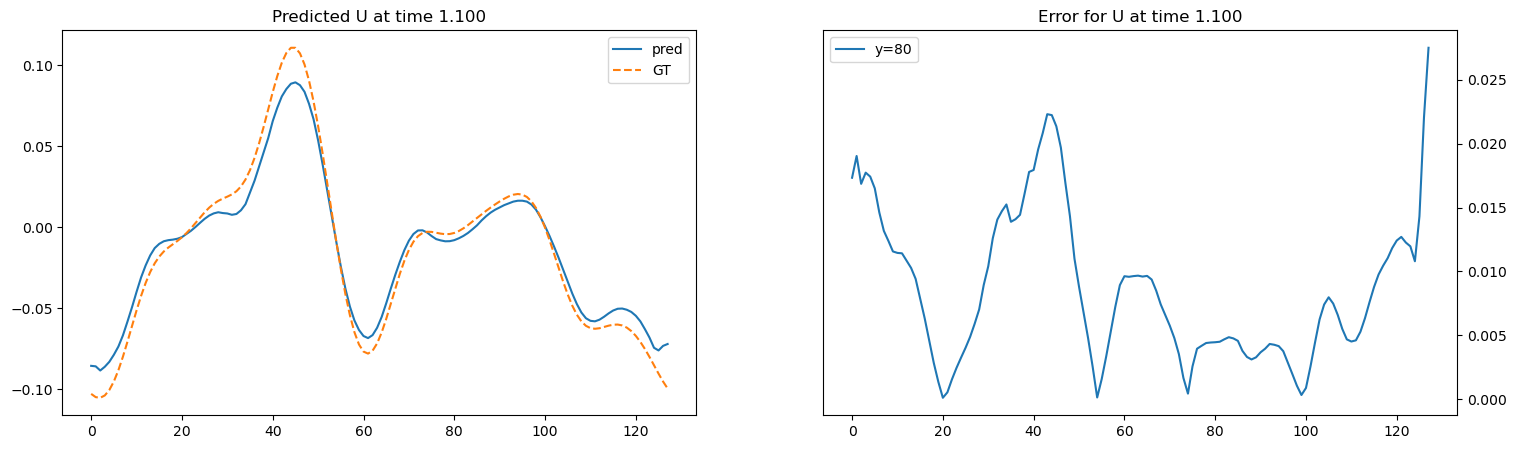

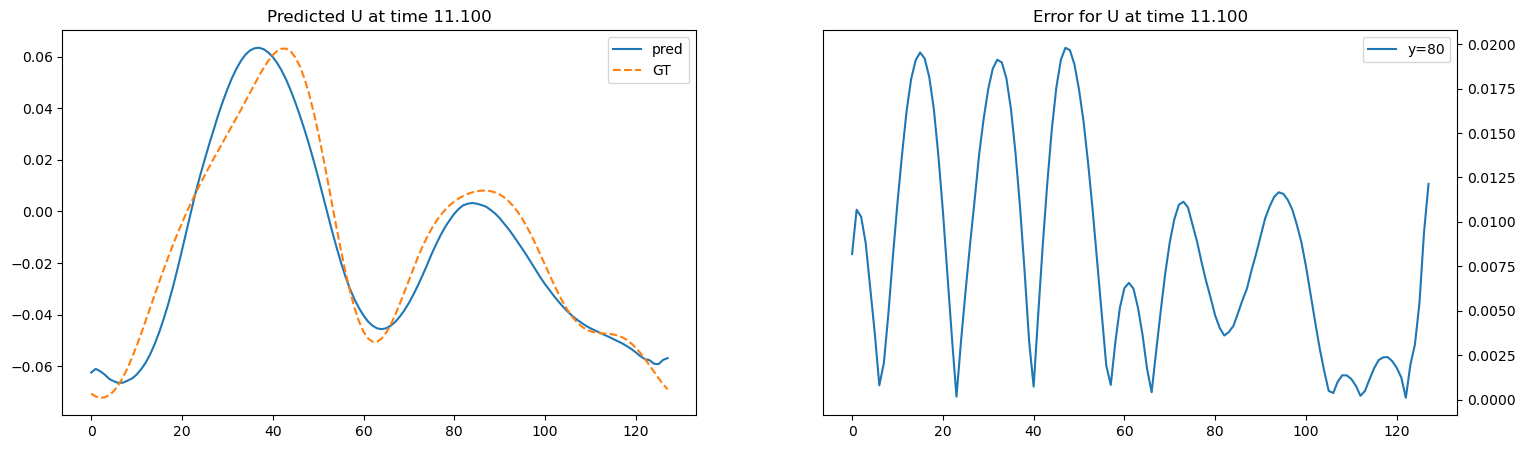

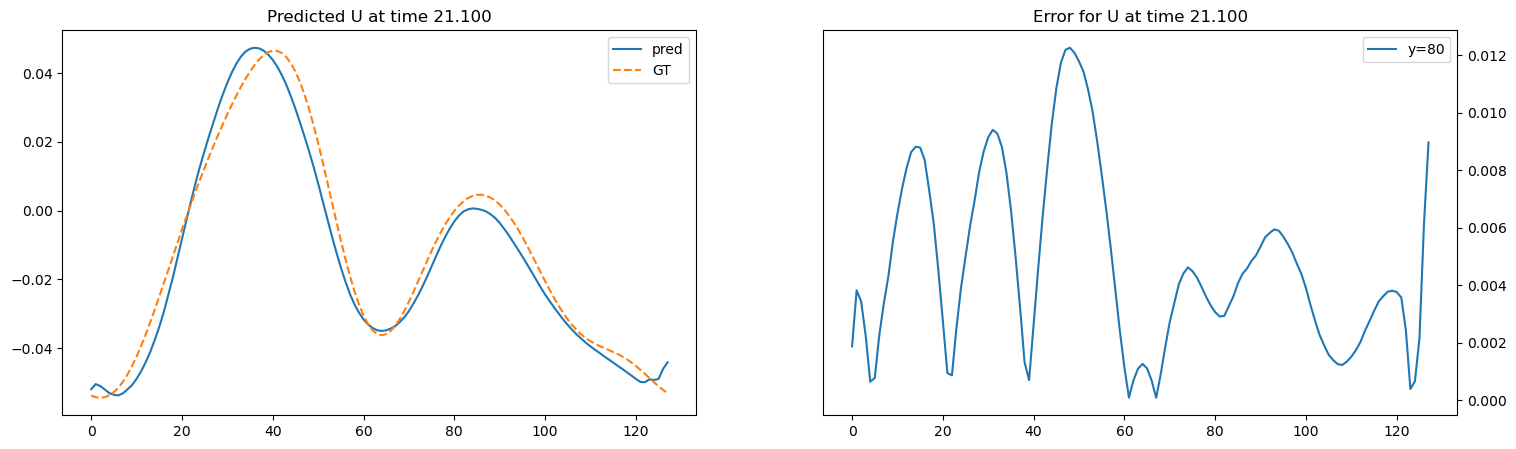

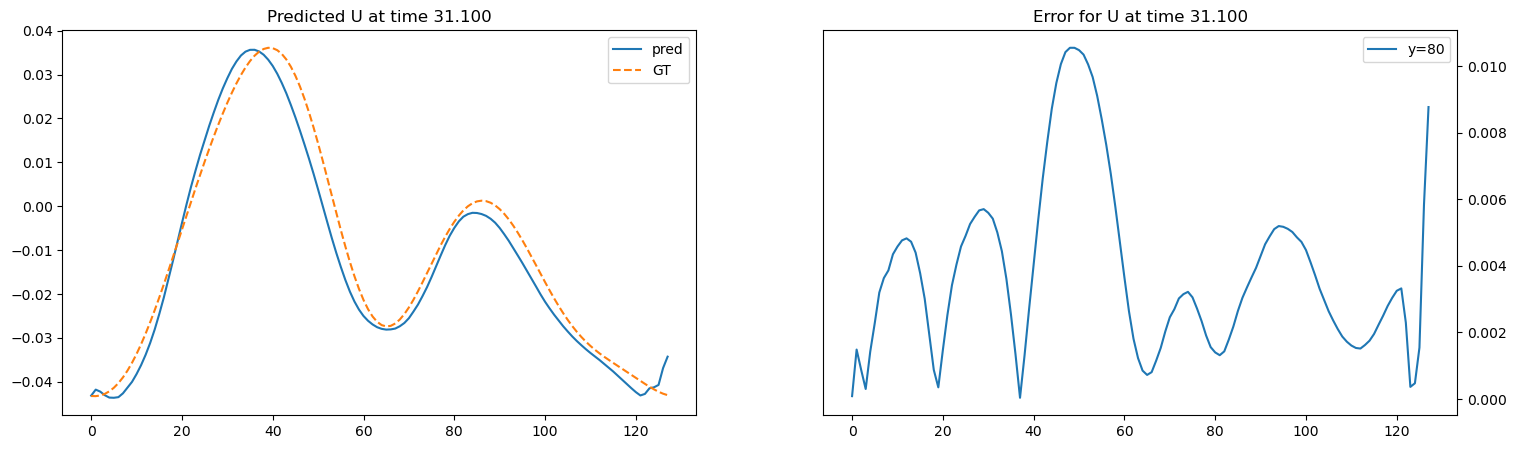

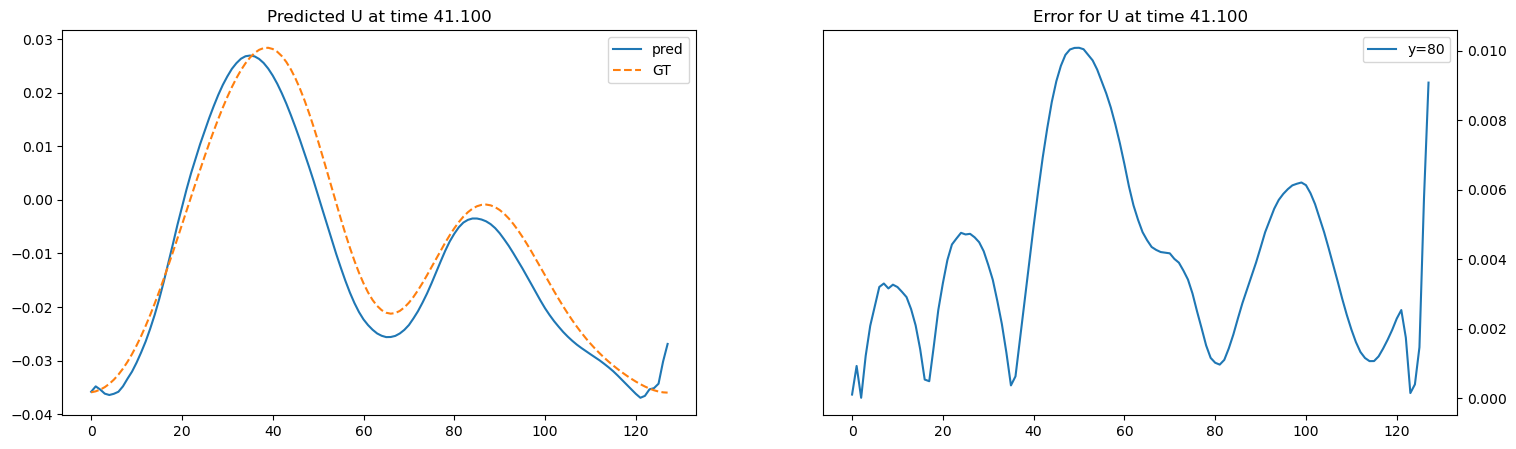

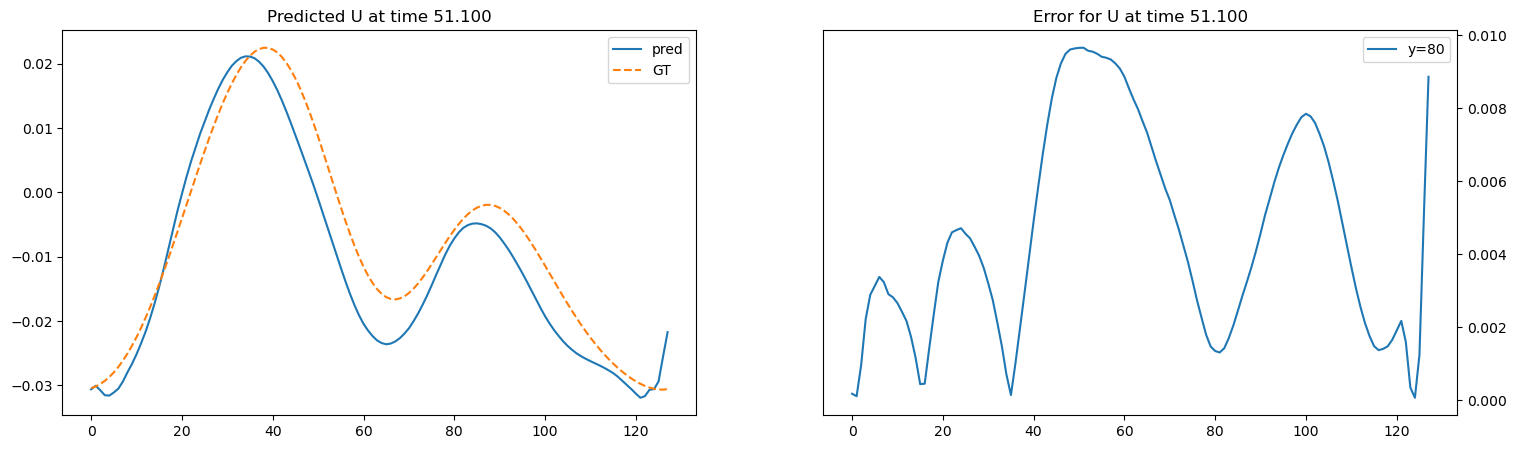

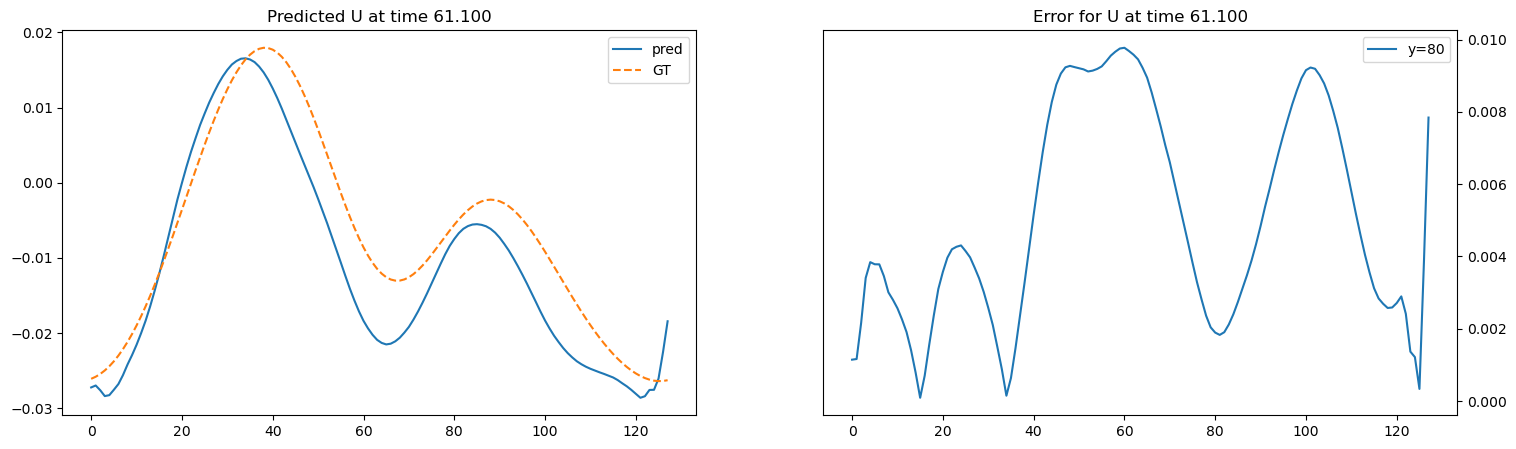

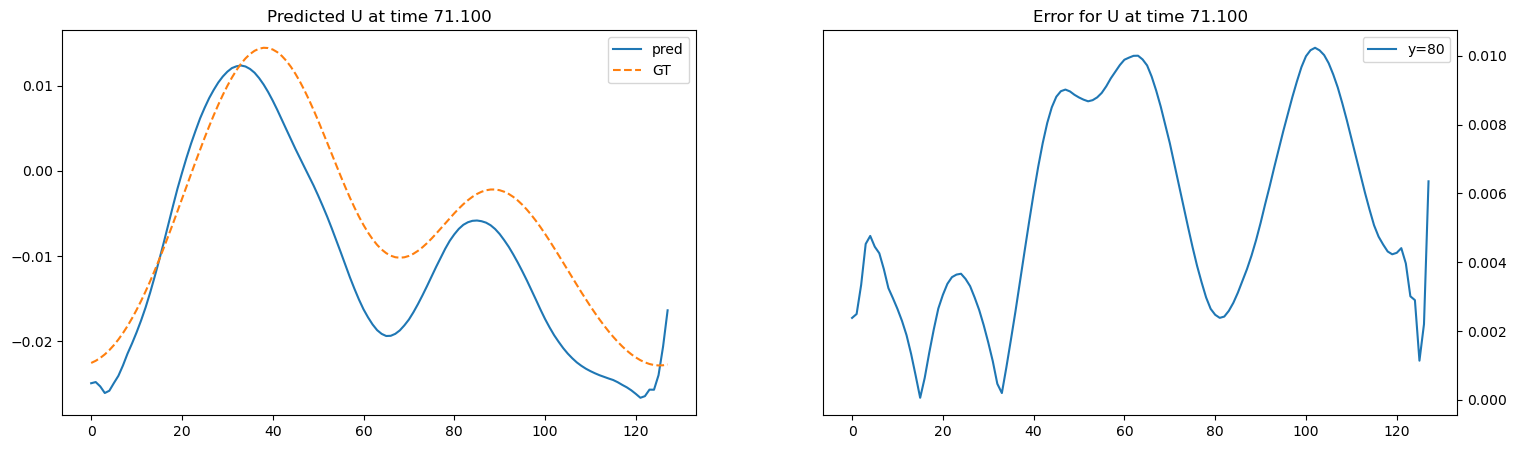

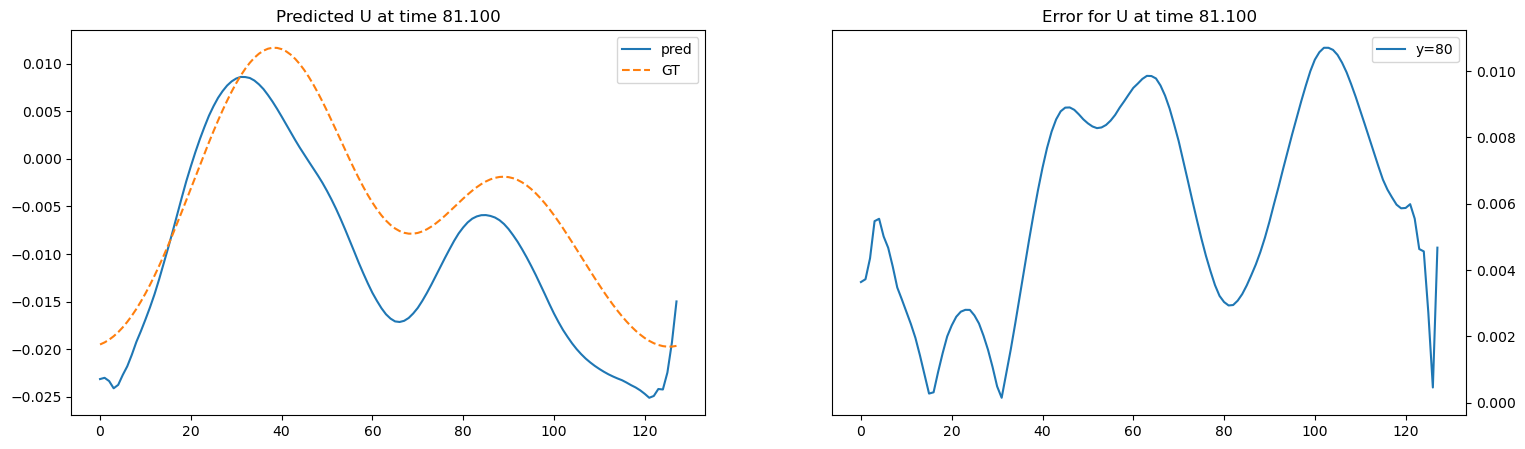

In [21]:
j= 80
for i in range(0, 900, 100):
    plt.figure(figsize=(18, 5))
    time_value = 0.1 * (11 + i)
    time_str = f"{time_value:.3f}" 

    # Left plot: Predicted U
    plt.subplot(1, 2, 1)
   
    plt.plot(pred_sequence_u[i, :, j].detach().cpu().numpy(), label=f'pred')
    plt.plot(gt_u[i, :, j].detach().cpu().numpy(), '--', label=f'GT')
    plt.title(f"Predicted U at time {time_str}")
    plt.legend()
   # plt.colorbar()

    # Fourth plot: Error along center slice
    plt.subplot(1, 2, 2)
   
    plt.plot(np.abs(pred_sequence_u[i, :, j].detach().cpu().numpy() -gt_u[i, :, j].detach().cpu().numpy()), label=f'y={j}')
    plt.legend()
    plt.title(f"Error for U at time {time_str}")
    
    # Set y-ticks on the right
    plt.gca().yaxis.tick_right()
    #plt.savefig(f'./figures/ntime_liftedfunet/liftedfunet_training_result_time={(i + 11)}_GS_FD_multi_traj_data_random_IC_tmax=2_sigma=5_numterms=20_extrapolation_IC={idx}_fixed_x_y={j}.png')
    plt.show()


In [22]:
def compute_radial_energy_spectrum(matrix, num_bins=32):
    """
    Compute the radial energy spectrum for a 2D input matrix.

    Parameters:
    - matrix: 2D numpy array (spatial domain)
    - num_bins: Number of bins for the radial spectrum (each bin with a width of 1)

    Returns:
    - energy_bins: 1D array containing the total energy in each radial bin
    - bin_edges: Array of bin edges used in the histogram
    """
    # Compute the 2D FFT and shift zero frequency to the center
    F = np.fft.fft2(matrix)
    F_shifted = np.fft.fftshift(F)
    
    # Compute the energy (squared magnitude)
    energy = np.abs(F_shifted)**2

    # Get dimensions and compute distance (wave number) from the center
    nrows, ncols = matrix.shape
    center_row, center_col = nrows // 2, ncols // 2
    y, x = np.indices((nrows, ncols))
    r = np.sqrt((x - center_col)**2 + (y - center_row)**2)
    
    # Define bins from 0 to num_bins (each bin width = 1)
    bin_edges = np.arange(0, num_bins + 1, 1)
    
    # Sum the energy in each radial bin
    energy_bins, _ = np.histogram(r, bins=bin_edges, weights=energy)
    
    return energy_bins, bin_edges

In [23]:
def compare_radial_spectra(pred_sequence, gt_sequence, num_bins=32):
    """
    Compute the radial energy spectra for both pred_sequence and gt_sequence.
    
    Parameters:
    - pred_sequence: numpy array of shape (T, dim, dim) for the predicted data
    - gt_sequence: numpy array of shape (T, dim, dim) for the ground truth data
    - num_bins: number of radial bins
    
    Returns:
    - pred_spectra: array of shape (T, num_bins) with radial energies for pred_sequence
    - gt_spectra: array of shape (T, num_bins) with radial energies for gt_sequence
    - bin_edges: the bin edges used in the computation
    """
    T = 900
    print(T)
    pred_spectra = []
    gt_spectra = []
    
    for t in range(T):
        pred_energy, bin_edges = compute_radial_energy_spectrum(pred_sequence[t], num_bins)
        gt_energy, _ = compute_radial_energy_spectrum(gt_sequence[t], num_bins)
        pred_spectra.append(pred_energy)
        gt_spectra.append(gt_energy)
    
    pred_spectra = np.array(pred_spectra)
    gt_spectra = np.array(gt_spectra)
    
    return pred_spectra, gt_spectra, bin_edges

In [24]:
def plot_average_spectra(pred_spectra, gt_spectra, bin_edges):
    """
    Plot the average radial energy spectrum for the predicted and ground truth sequences.
    
    Parameters:
    - pred_spectra: array of shape (T, num_bins)
    - gt_spectra: array of shape (T, num_bins)
    - bin_edges: bin edges array from the spectrum calculation
    """
    # Average spectra over time steps
    pred_avg = np.mean(pred_spectra, axis=0)
    gt_avg = np.mean(gt_spectra, axis=0)
    
    # Compute bin centers for plotting
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    for i in range(0, len(pred_spectra), 100):
        plt.figure(figsize=(8, 5))
        plt.semilogy(bin_centers, pred_spectra[i], marker='o', label='Predicted')
        plt.semilogy(bin_centers, gt_spectra[i], marker='o', label='Ground Truth')
        plt.xlabel('Wave number')
        plt.ylabel('Energy')
        time_value = 0.1 * (11 + i)
        time_str = f"{time_value:.3f}" 
        plt.title(r'Radial Energy Spectrum time t = ' + time_str)
        plt.legend()
        plt.grid(True)
        #plt.savefig(f'./figures/ntime_liftedfunet/liftedfunet_energy_spectrum_training_result_time={(i + 11)}_GS_FD_multi_traj_data_random_IC_tmax=2_sigma=5_numterms=20_extrapolation_IC={idx}.png')
        plt.show()
    plt.figure(figsize=(8, 5))
    plt.semilogy(bin_centers, pred_avg, marker='o', label='Predicted')
    plt.semilogy(bin_centers, gt_avg, marker='o', label='Ground Truth')
    plt.xlabel('Wave number')
    plt.ylabel('Energy')
    plt.title('Average Radial Energy Spectrum')
    plt.legend()
    plt.grid(True)
    #plt.savefig(f'./figures/ntime_liftedfunet/liftedfunet_avg_energy_spectrum_training_result_time={(i + 11)}_GS_FD_multi_traj_data_random_IC_tmax=2_sigma=5_numterms=20_extrapolation_IC={idx}.png')
    plt.show()

In [25]:
pred_spectra, gt_spectra, bin_edges = compare_radial_spectra(pred_sequence_u.cpu().detach().numpy(), gt_u.cpu().detach().numpy(), num_bins=64)

900


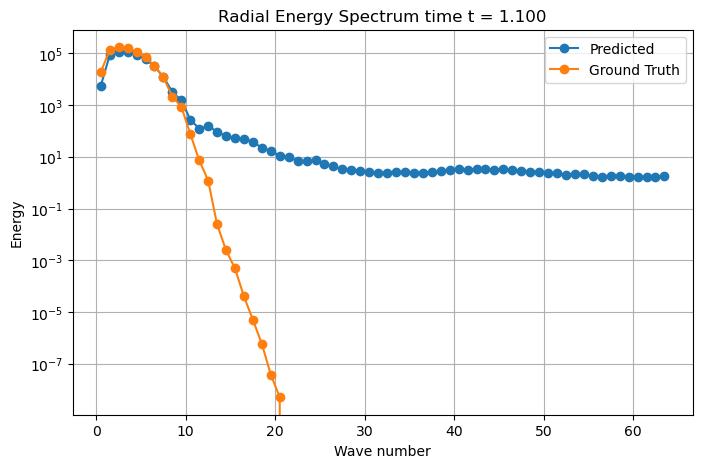

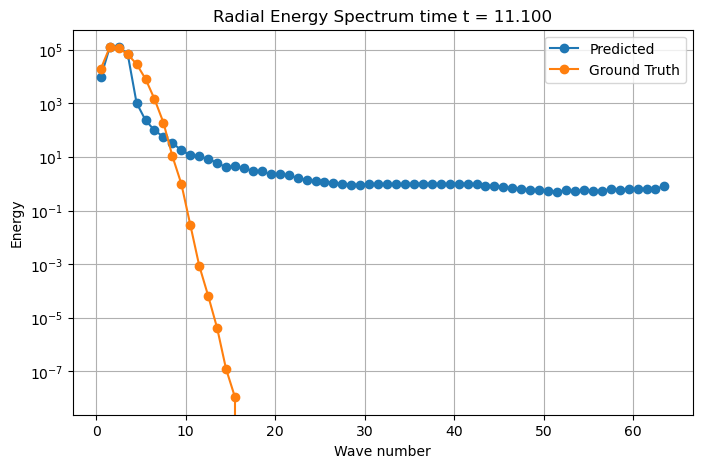

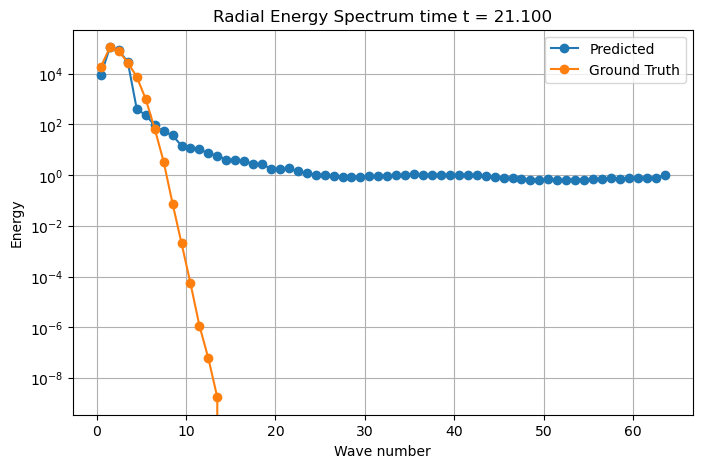

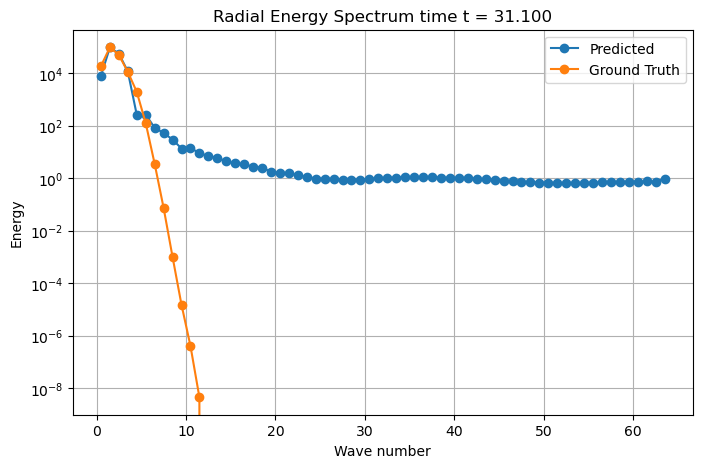

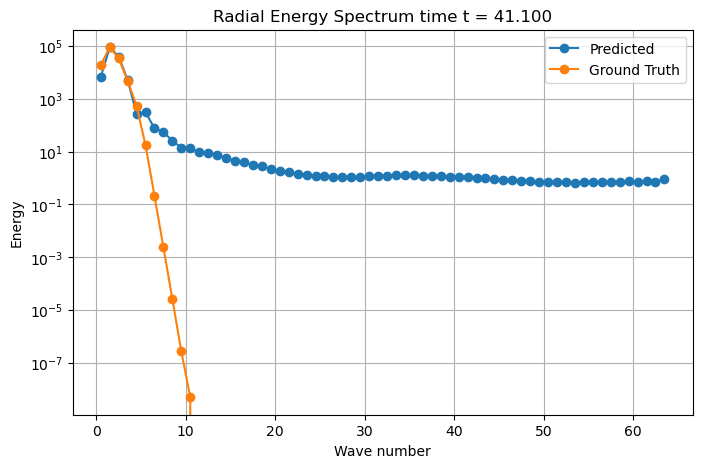

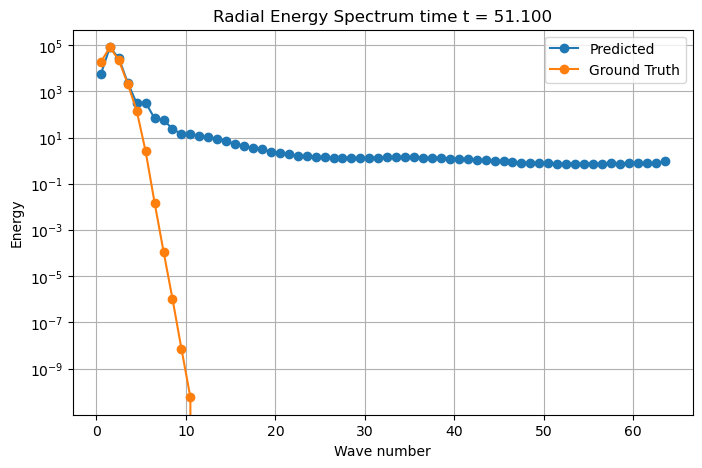

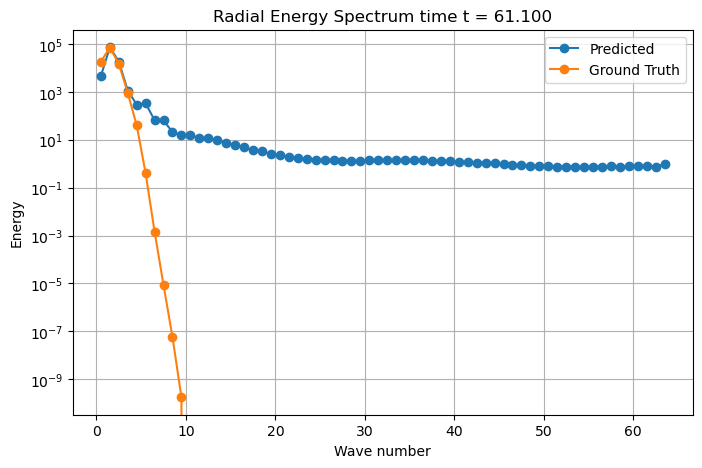

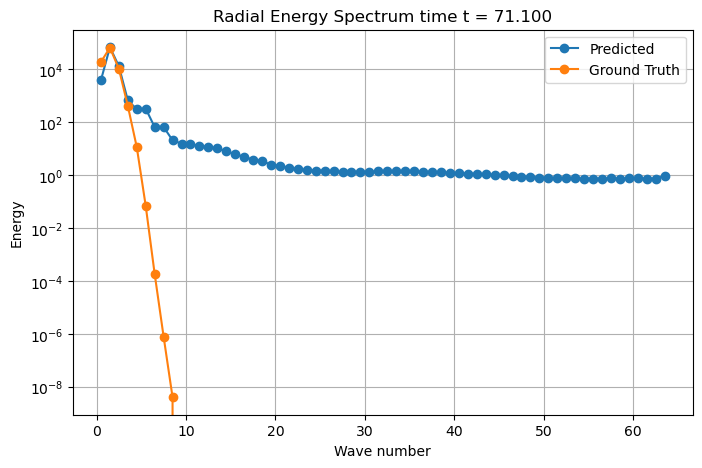

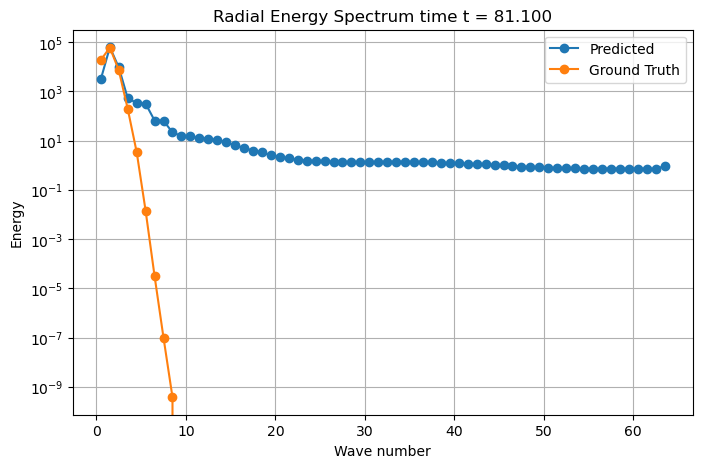

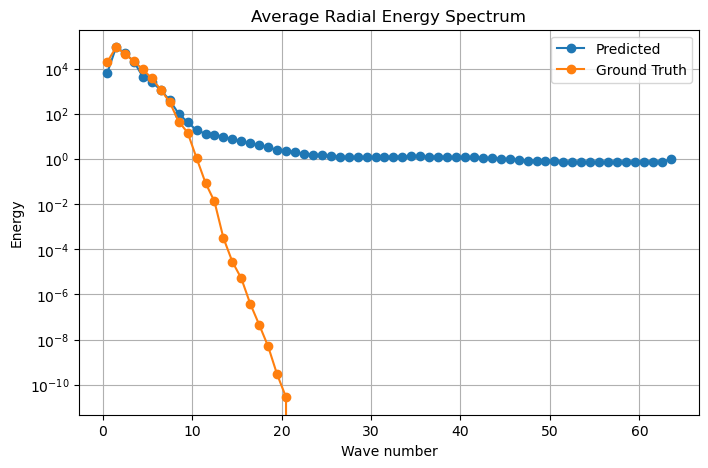

In [26]:
plot_average_spectra(pred_spectra, gt_spectra, bin_edges)

In [27]:
# Number of trainable parameters (those with gradients)
trainable_params = sum(p.numel() for p in model_u.parameters() if p.requires_grad)
print("Trainable parameters:", trainable_params)

Trainable parameters: 52843076
